---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [3]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys
sys.path.append('./scripts')
from helpers import load_wands_products, load_wands_queries, load_wands_labels

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

All imports successful!


In [5]:
# Load the WANDS dataset
products = load_wands_products(data_dir="./data")  # Changed to ./data
queries = load_wands_queries(data_dir="./data")
labels = load_wands_labels(data_dir="./data")

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [6]:
# Copy your BM25 functions from Homework 3

import Stemmer
import string
from collections import Counter

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def tokenize(text: str) -> list[str]:
    """Tokenize with stemming."""
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """Build inverted index."""
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def score_bm25(query: str, index: dict, doc_lengths: list[int], 
               num_docs: int, tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """Calculate BM25 scores."""
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths)
    
    for term in query_tokens:
        if term not in index:
            continue
        
        df = len(index[term])
        idf = np.log((num_docs - df + 0.5) / (df + 0.5))
        
        for doc_id in range(num_docs):
            if doc_id in index[term]:
                tf = index[term][doc_id]
                doc_len = doc_lengths[doc_id]
                norm = 1 - b + b * (doc_len / avg_doc_len)
                tf_component = (tf * (k1 + 1)) / (tf + k1 * norm)
                scores[doc_id] += idf * tf_component
    
    return scores

print("BM25 functions copied from HW3!")

BM25 functions copied from HW3!


---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [7]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each word in the list
words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]

embeddings = model.encode(words)

# Print the number of embeddings you generated and the dimension of the embeddings
print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimension of embeddings: {embeddings.shape[1]}")
print(f"Shape: {embeddings.shape}")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2728.27it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of embeddings: 5
Dimension of embeddings: 384
Shape: (5, 384)


### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [8]:
# Implement cosine similarity from scratch
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """
    Calculate cosine similarity between two vectors.
    Formula: (a · b) / (||a|| × ||b||)
    """
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# Create similarity matrix
n = len(embeddings)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

# Display as DataFrame
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=words,
    columns=words
)

print("Similarity Matrix:")
print(similarity_df.round(3))

Similarity Matrix:
                     wooden coffee table  oak dining table  red leather sofa  \
wooden coffee table                1.000             0.589             0.371   
oak dining table                   0.589             1.000             0.338   
red leather sofa                   0.371             0.338             1.000   
blue area rug                      0.189             0.250             0.380   
kitchen sink                       0.296             0.341             0.058   

                     blue area rug  kitchen sink  
wooden coffee table          0.189         0.296  
oak dining table             0.250         0.341  
red leather sofa             0.380         0.058  
blue area rug                1.000         0.126  
kitchen sink                 0.126         1.000  


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [9]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
response = litellm.embedding(
    model="text-embedding-3-small",
    input=["wooden coffee table"]
)

openai_embedding = response.data[0]['embedding']

# Compare the dimension with the local model
print(f"Local model (MiniLM) dimension: {embeddings.shape[1]}")
print(f"OpenAI embedding dimension: {len(openai_embedding)}")
print(f"\nOpenAI embeddings are {len(openai_embedding) / embeddings.shape[1]:.1f}x larger")

Local model (MiniLM) dimension: 384
OpenAI embedding dimension: 1536

OpenAI embeddings are 4.0x larger


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [10]:
# Get a consistent sample
np.random.seed(42)
sample_indices = np.random.choice(len(products), size=5000, replace=False)
products_sample = products.iloc[sample_indices].reset_index(drop=True)

print(f"Sampled {len(products_sample)} products")
print(products_sample[['product_name', 'product_class']].head())

Sampled 5000 products
                                  product_name  \
0                            woven wire basket   
1                           scallop nightstand   
2            ybm home stainless steel colander   
3  oneida 2 piece stainless steel strainer set   
4                    ryland platform bed frame   

                            product_class  
0         Boxes, Bins, Baskets, & Buckets  
1                        Kids Nightstands  
2  Strainers, Colanders, & Salad Spinners  
3  Strainers, Colanders, & Salad Spinners  
4                         Bed Frames|Beds  


In [11]:
# Create a combined text field (product_name + product_class)
products_sample['combined_text'] = (
    products_sample['product_name'].fillna('') + ' ' + 
    products_sample['product_class'].fillna('')
)

# Embed all products using model.encode()
print("Embedding products... (this may take 30-60 seconds)")
start_time = time.time()

product_embeddings = model.encode(
    products_sample['combined_text'].tolist(),
    show_progress_bar=True
)

elapsed = time.time() - start_time

print(f"\nEmbedded {len(product_embeddings)} products in {elapsed:.1f} seconds")
print(f"Embedding shape: {product_embeddings.shape}")
print(f"Speed: {len(product_embeddings)/elapsed:.0f} products/second")

Embedding products... (this may take 30-60 seconds)


Batches: 100%|██████████| 157/157 [00:05<00:00, 29.25it/s]


Embedded 5000 products in 5.4 seconds
Embedding shape: (5000, 384)
Speed: 929 products/second


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [12]:
# Save embeddings to ../temp/hw4_embeddings.npy
import os
os.makedirs('../temp', exist_ok=True)

np.save('../temp/hw4_embeddings.npy', product_embeddings)
products_sample.to_csv('../temp/hw4_products.csv', index=False)

print("Saved embeddings and products")

# Load them back and verify they match
loaded_embeddings = np.load('../temp/hw4_embeddings.npy')
loaded_products = pd.read_csv('../temp/hw4_products.csv')

print(f"\nLoaded embeddings shape: {loaded_embeddings.shape}")
print(f"Loaded products: {len(loaded_products)}")
print(f"Match: {np.allclose(product_embeddings, loaded_embeddings)}")

Saved embeddings and products

Loaded embeddings shape: (5000, 384)
Loaded products: 5000
Match: True


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [13]:
# Use tiktoken to count actual tokens in the sample
import tiktoken

encoding = tiktoken.encoding_for_model("text-embedding-3-small")

# Count tokens in sample
total_tokens = 0
for text in products_sample['combined_text']:
    total_tokens += len(encoding.encode(text))

# Calculate cost for sample
cost_per_million = 0.02  # $0.02 per 1M tokens
sample_cost = (total_tokens / 1_000_000) * cost_per_million

# Extrapolate to full dataset
full_dataset_tokens = total_tokens * (len(products) / len(products_sample))
full_cost = (full_dataset_tokens / 1_000_000) * cost_per_million

print(f"Sample statistics:")
print(f"  Products: {len(products_sample):,}")
print(f"  Total tokens: {total_tokens:,}")
print(f"  Cost: ${sample_cost:.4f}")
print(f"\nFull dataset estimate:")
print(f"  Products: {len(products):,}")
print(f"  Estimated tokens: {full_dataset_tokens:,.0f}")
print(f"  Estimated cost: ${full_cost:.2f}")

Sample statistics:
  Products: 5,000
  Total tokens: 65,077
  Cost: $0.0013

Full dataset estimate:
  Products: 42,994
  Estimated tokens: 559,584
  Estimated cost: $0.01


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [14]:
# Implement batch cosine similarity for efficiency
def batch_cosine_similarity(query_embedding: np.ndarray, 
                           document_embeddings: np.ndarray) -> np.ndarray:
    """
    Calculate cosine similarity between a query and all documents efficiently.
    
    Args:
        query_embedding: Shape (embedding_dim,)
        document_embeddings: Shape (num_docs, embedding_dim)
        
    Returns:
        similarities: Shape (num_docs,)
    """
    # Normalize query
    query_norm = query_embedding / np.linalg.norm(query_embedding)
    
    # Normalize documents
    doc_norms = np.linalg.norm(document_embeddings, axis=1, keepdims=True)
    docs_normalized = document_embeddings / doc_norms
    
    # Dot product gives cosine similarity when vectors are normalized
    similarities = np.dot(docs_normalized, query_norm)
    
    return similarities

In [15]:
# Implement semantic search
def semantic_search(query: str, products_df: pd.DataFrame, 
                   embeddings: np.ndarray, model: SentenceTransformer,
                   k: int = 10) -> pd.DataFrame:
    """
    Search products using semantic similarity.
    
    Args:
        query: Search query string
        products_df: DataFrame of products
        embeddings: Product embeddings matrix
        model: Embedding model
        k: Number of results to return
        
    Returns:
        DataFrame with top k results
    """
    # Embed the query
    query_embedding = model.encode([query])[0]
    
    # Calculate similarities
    similarities = batch_cosine_similarity(query_embedding, embeddings)
    
    # Get top k indices
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    
    # Create results DataFrame
    results = products_df.iloc[top_k_indices].copy()
    results['similarity'] = similarities[top_k_indices]
    
    return results[['product_name', 'product_class', 'similarity']]

print("Semantic search function implemented!")

Semantic search function implemented!


In [17]:
# Test semantic search
test_query = "comfortable leather couch"
results = semantic_search(test_query, products_sample, product_embeddings, model, k=10)

print(f"Semantic search results for '{test_query}':\n")
print(results)

Semantic search results for 'comfortable leather couch':

                                                          product_name  \
2769                           124 '' wide leather match sofa & chaise   
4046                                  chafin contemporary leather sofa   
4768                               castilloux patio sofa with cushions   
2414                                  leather upholstered dining chair   
2631                                    yland patio sofa with cushions   
2736                                   baeten patio sofa with cushions   
730               linnell 44 '' wide tufted top grain leather armchair   
611                                  arshleen patio sofa with cushions   
2928                                      aniline leather office chair   
2408  adcock faux leather right hand facing sofa & chaise with ottoman   

                          product_class  similarity  
2769                         Sectionals    0.674155  
4046  Reception Sof

### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [18]:
# Implement Recall@k
def recall_at_k(retrieved_ids: list, relevant_ids: list, k: int) -> float:
    """
    Calculate Recall@k.
    
    Recall@k = (# of relevant items in top k) / (total # of relevant items)
    """
    retrieved_set = set(retrieved_ids[:k])
    relevant_set = set(relevant_ids)
    
    if len(relevant_set) == 0:
        return 0.0
    
    hits = len(retrieved_set & relevant_set)
    return hits / len(relevant_set)

print("Recall@k function implemented!")

Recall@k function implemented!


In [19]:
# Build BM25 index for comparison
combined_texts = products_sample['combined_text'].tolist()
bm25_index, bm25_lengths = build_index(combined_texts, tokenize)

print(f"Built BM25 index with {len(bm25_index)} unique terms")

# Filter queries to those with products in our sample
sample_product_ids = set(products_sample['product_id'])
sample_labels = labels[labels['product_id'].isin(sample_product_ids)]
sample_query_ids = sample_labels['query_id'].unique()
queries_filtered = queries[queries['query_id'].isin(sample_query_ids)]

print(f"Filtered to {len(queries_filtered)} queries with products in our sample")

Built BM25 index with 5843 unique terms
Filtered to 473 queries with products in our sample


In [20]:
# Evaluate both BM25 and semantic search on all queries
bm25_recalls = []
semantic_recalls = []

for _, query_row in queries_filtered.iterrows():
    query_id = query_row['query_id']
    query_text = query_row['query']
    
    # Get relevant product IDs
    query_labels = sample_labels[sample_labels['query_id'] == query_id]
    relevant_ids = query_labels[query_labels['grade'] > 0]['product_id'].tolist()
    
    if len(relevant_ids) == 0:
        continue
    
    # BM25 search
    bm25_scores = score_bm25(query_text, bm25_index, bm25_lengths, 
                            len(products_sample), tokenize)
    bm25_top_indices = np.argsort(bm25_scores)[-10:][::-1]
    bm25_top_ids = products_sample.iloc[bm25_top_indices]['product_id'].tolist()
    bm25_recall = recall_at_k(bm25_top_ids, relevant_ids, k=10)
    
    # Semantic search
    query_emb = model.encode([query_text])[0]
    similarities = batch_cosine_similarity(query_emb, product_embeddings)
    sem_top_indices = np.argsort(similarities)[-10:][::-1]
    sem_top_ids = products_sample.iloc[sem_top_indices]['product_id'].tolist()
    sem_recall = recall_at_k(sem_top_ids, relevant_ids, k=10)
    
    bm25_recalls.append(bm25_recall)
    semantic_recalls.append(sem_recall)

# Calculate averages
print(f"Evaluated {len(bm25_recalls)} queries")
print(f"\nBM25 Mean Recall@10: {np.mean(bm25_recalls):.4f}")
print(f"Semantic Mean Recall@10: {np.mean(semantic_recalls):.4f}")

Evaluated 471 queries

BM25 Mean Recall@10: 0.3718
Semantic Mean Recall@10: 0.3267


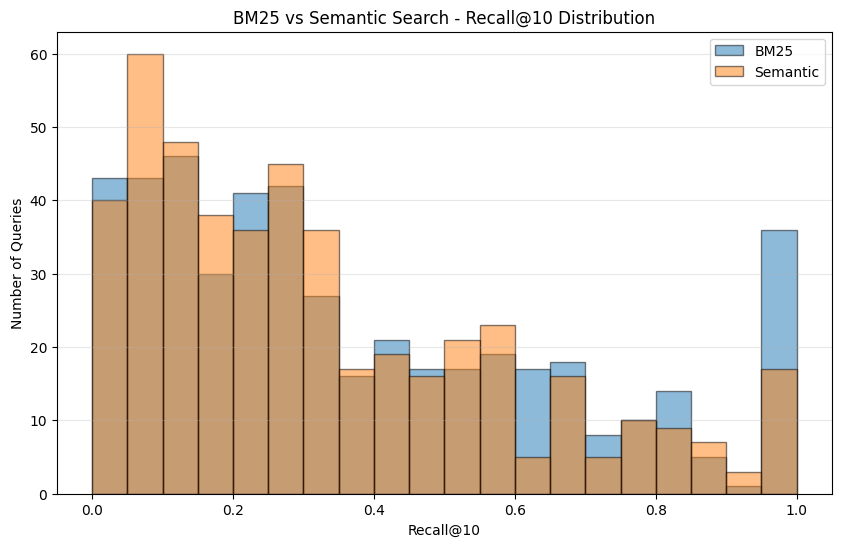

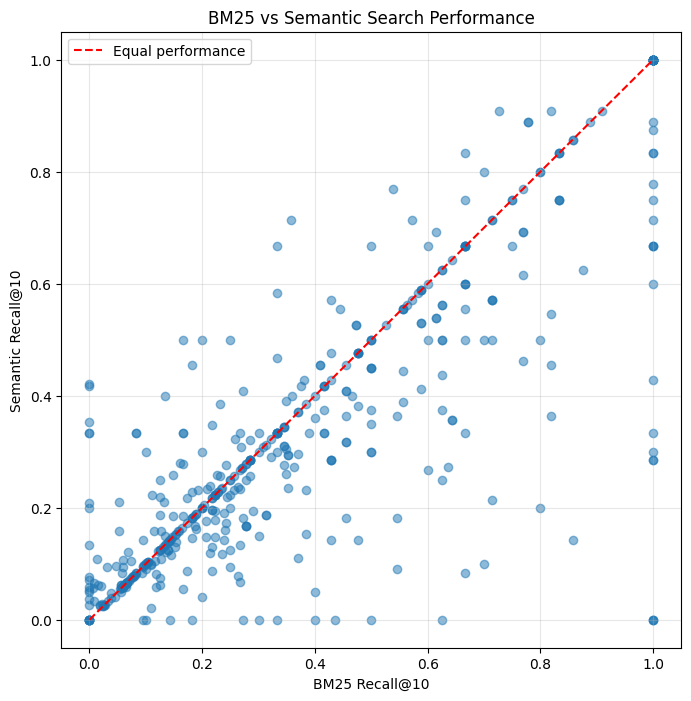

In [21]:
# Visualize comparison
plt.figure(figsize=(10, 6))
plt.hist(bm25_recalls, bins=20, alpha=0.5, label='BM25', edgecolor='black')
plt.hist(semantic_recalls, bins=20, alpha=0.5, label='Semantic', edgecolor='black')
plt.xlabel('Recall@10')
plt.ylabel('Number of Queries')
plt.title('BM25 vs Semantic Search - Recall@10 Distribution')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(bm25_recalls, semantic_recalls, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', label='Equal performance')
plt.xlabel('BM25 Recall@10')
plt.ylabel('Semantic Recall@10')
plt.title('BM25 vs Semantic Search Performance')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [22]:
# Load the two embedding models
print("Loading BGE model...")
model_bge = SentenceTransformer('BAAI/bge-base-en-v1.5')

print("Loading MPNet model...")
model_mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

print("\nModel dimensions:")
print(f"  BGE: {model_bge.get_sentence_embedding_dimension()}")
print(f"  MPNet: {model_mpnet.get_sentence_embedding_dimension()}")

Loading BGE model...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1700.67it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading MPNet model...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2758.63it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Model dimensions:
  BGE: 768
  MPNet: 768


In [23]:
# Embed products with both models
print("Embedding with BGE...")
embeddings_bge = model_bge.encode(
    products_sample['combined_text'].tolist(),
    show_progress_bar=True
)

print("\nEmbedding with MPNet...")
embeddings_mpnet = model_mpnet.encode(
    products_sample['combined_text'].tolist(),
    show_progress_bar=True
)

print(f"\nBGE embeddings shape: {embeddings_bge.shape}")
print(f"MPNet embeddings shape: {embeddings_mpnet.shape}")

Embedding with BGE...


Batches: 100%|██████████| 157/157 [00:11<00:00, 14.09it/s]



Embedding with MPNet...


Batches: 100%|██████████| 157/157 [00:13<00:00, 11.44it/s]


BGE embeddings shape: (5000, 768)
MPNet embeddings shape: (5000, 768)


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.

In [24]:
# Evaluate both models
bge_recalls = []
mpnet_recalls = []

for _, query_row in queries_filtered.iterrows():
    query_id = query_row['query_id']
    query_text = query_row['query']
    
    query_labels = sample_labels[sample_labels['query_id'] == query_id]
    relevant_ids = query_labels[query_labels['grade'] > 0]['product_id'].tolist()
    
    if len(relevant_ids) == 0:
        continue
    
    # BGE search
    query_emb_bge = model_bge.encode([query_text])[0]
    sim_bge = batch_cosine_similarity(query_emb_bge, embeddings_bge)
    top_bge = np.argsort(sim_bge)[-10:][::-1]
    ids_bge = products_sample.iloc[top_bge]['product_id'].tolist()
    recall_bge = recall_at_k(ids_bge, relevant_ids, k=10)
    
    # MPNet search
    query_emb_mpnet = model_mpnet.encode([query_text])[0]
    sim_mpnet = batch_cosine_similarity(query_emb_mpnet, embeddings_mpnet)
    top_mpnet = np.argsort(sim_mpnet)[-10:][::-1]
    ids_mpnet = products_sample.iloc[top_mpnet]['product_id'].tolist()
    recall_mpnet = recall_at_k(ids_mpnet, relevant_ids, k=10)
    
    bge_recalls.append(recall_bge)
    mpnet_recalls.append(recall_mpnet)

print(f"BGE Mean Recall@10: {np.mean(bge_recalls):.4f}")
print(f"MPNet Mean Recall@10: {np.mean(mpnet_recalls):.4f}")

BGE Mean Recall@10: 0.3335
MPNet Mean Recall@10: 0.3162


In [25]:
# Compare results for specific queries
test_queries = ["comfortable sofa", "star wars rug", "modern coffee table", "wooden bed frame", "outdoor furniture"]

for query in test_queries:
    print(f"\n{'='*60}")
    print(f"Query: '{query}'")
    print('='*60)
    
    # BGE results
    bge_results = semantic_search(query, products_sample, embeddings_bge, model_bge, k=3)
    print("\nBGE Top 3:")
    for i, row in bge_results.iterrows():
        print(f"  {row['product_name'][:50]} ({row['similarity']:.3f})")
    
    # MPNet results
    mpnet_results = semantic_search(query, products_sample, embeddings_mpnet, model_mpnet, k=3)
    print("\nMPNet Top 3:")
    for i, row in mpnet_results.iterrows():
        print(f"  {row['product_name'][:50]} ({row['similarity']:.3f})")


Query: 'comfortable sofa'

BGE Top 3:
  baeten patio sofa with cushions (0.809)
  94 '' square arm sofa with reversible cushions (0.805)
  mccaffery 74 '' round arm sofa (0.801)

MPNet Top 3:
  arshleen patio sofa with cushions (0.748)
  aidann patio sectional with cushions (0.747)
  lucey patio sectional with cushions (0.736)

Query: 'star wars rug'

BGE Top 3:
  dinosaur land area rug (0.778)
  trisler hand-tufted gray/beige area rug (0.765)
  dunfries geometric shag gray/white area rug (0.760)

MPNet Top 3:
  runner brandt oriental hand-knotted wool beige are (0.614)
  rugsotic carpets hand-knotted silk blue area rug (0.612)
  novelty shayne patchwork cowhide leather gradient  (0.609)

Query: 'modern coffee table'

BGE Top 3:
  coffee table with storage (0.851)
  florie solid coffee table (0.845)
  tacto solid wood block coffee table (0.820)

MPNet Top 3:
  coffee table (0.829)
  updegraff contemporary rect coffee table (0.808)
  choual coffee table (0.805)

Query: 'wooden bed fram

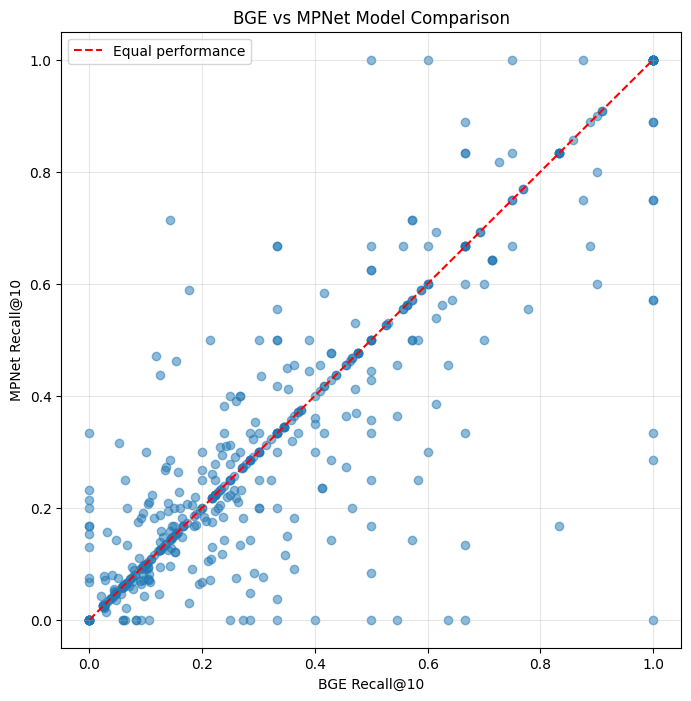


Model Comparison Summary:
  BGE wins: 147 queries
  MPNet wins: 121 queries
  Ties: 203 queries


In [26]:
# Visualize model comparison with a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(bge_recalls, mpnet_recalls, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--', label='Equal performance')
plt.xlabel('BGE Recall@10')
plt.ylabel('MPNet Recall@10')
plt.title('BGE vs MPNet Model Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Summary stats
print(f"\nModel Comparison Summary:")
print(f"  BGE wins: {sum(np.array(bge_recalls) > np.array(mpnet_recalls))} queries")
print(f"  MPNet wins: {sum(np.array(mpnet_recalls) > np.array(bge_recalls))} queries")
print(f"  Ties: {sum(np.array(bge_recalls) == np.array(mpnet_recalls))} queries")

---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.